In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('website_traffic.csv')

print("Data Information:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Page Views        2000 non-null   int64  
 1   Session Duration  2000 non-null   float64
 2   Bounce Rate       2000 non-null   float64
 3   Traffic Source    2000 non-null   object 
 4   Time on Page      2000 non-null   float64
 5   Previous Visits   2000 non-null   int64  
 6   Conversion Rate   2000 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 109.5+ KB
None

Summary Statistics:
        Page Views  Session Duration  Bounce Rate  Time on Page  \
count  2000.000000       2000.000000  2000.000000   2000.000000   
mean      4.950500          3.022045     0.284767      4.027439   
std       2.183903          3.104518     0.159781      2.887422   
min       0.000000          0.003613     0.007868      0.068515   
25%       3.000000          

In [71]:
print("\nMissing Values:")
print(df.isnull().sum())



Missing Values:
Page Views          0
Session Duration    0
Bounce Rate         0
Traffic Source      0
Time on Page        0
Previous Visits     0
Conversion Rate     0
dtype: int64


In [73]:
numeric_df = df.select_dtypes(include=[np.number])

correlations = numeric_df.corr()['Conversion Rate'].sort_values()
print("\nCorrelation Coefficients with Conversion Rate:")
print(correlations)

positive_correlations = correlations[correlations > 0].sort_values(ascending=False)
print("\nFeatures with Positive Correlation to Conversion Rate:")
print(positive_correlations)



Correlation Coefficients with Conversion Rate:
Bounce Rate        -0.049051
Previous Visits     0.109496
Page Views          0.126635
Session Duration    0.177798
Time on Page        0.229669
Conversion Rate     1.000000
Name: Conversion Rate, dtype: float64

Features with Positive Correlation to Conversion Rate:
Conversion Rate     1.000000
Time on Page        0.229669
Session Duration    0.177798
Page Views          0.126635
Previous Visits     0.109496
Name: Conversion Rate, dtype: float64


In [75]:
if positive_correlations.empty:
    raise ValueError("No features with positive correlation to the target variable.")

target = 'Conversion Rate'
features = positive_correlations.index.drop(target)

if target not in numeric_df.columns:
    raise ValueError(f"Target variable '{target}' not found in numeric columns.")

X = numeric_df[features].values
y = numeric_df[target].values


In [77]:
splitRatio = 0.8  
splitIndex = int(len(X) * splitRatio)  

xTrain, xTest = X[:splitIndex], X[splitIndex:]
yTrain, yTest = y[:splitIndex], y[splitIndex:]


In [79]:
xTrainB = np.c_[np.ones((xTrain.shape[0], 1)), xTrain]  
result = np.linalg.inv(xTrainB.T @ xTrainB) @ xTrainB.T @ yTrain

xTest_b = np.c_[np.ones((xTest.shape[0], 1)), xTest]  
yPred = xTest_b @ result


In [81]:
mae = np.mean(np.abs(yTest - yPred))
print(f"\nMean Absolute Error (MAE): {mae:.2f}")

print("\nAnalysis of MAE:")
if mae < 1:
    print("The Mean Absolute Error is relatively low, indicating that the model's predictions are close to the actual values. This suggests a good model performance.")
elif mae < 5:
    print("The Mean Absolute Error is moderate, suggesting that the model's predictions are reasonably accurate but there is room for improvement.")
else:
    print("The Mean Absolute Error is high, indicating that the model's predictions are far from the actual values. This suggests that the model's performance needs improvement.")



Mean Absolute Error (MAE): 0.03

Analysis of MAE:
The Mean Absolute Error is relatively low, indicating that the model's predictions are close to the actual values. This suggests a good model performance.


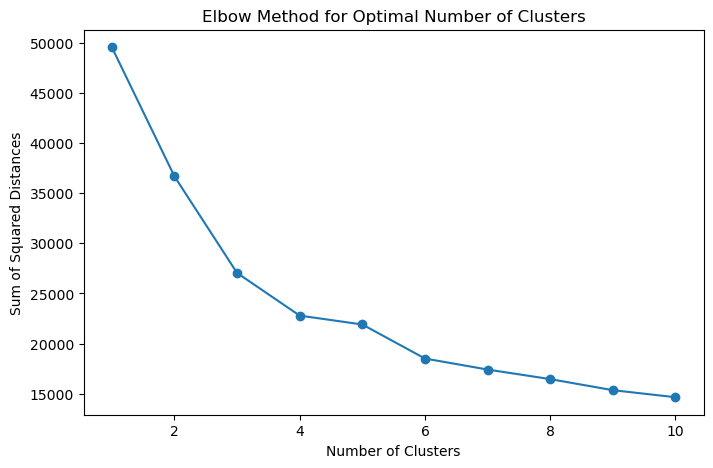

In [83]:
sse = []

for k in range(1, 11):
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    for _ in range(100):  
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        clusters = np.argmin(distances, axis=1)
        newCentroids = np.array([X[clusters == i].mean(axis=0) for i in range(k)])
        if np.all(centroids == newCentroids):
            break
        centroids = newCentroids
    sse.append(np.sum((X - centroids[clusters]) ** 2))

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()


In [85]:
optimalClusters = 3
centroids = X[np.random.choice(X.shape[0], optimalClusters, replace=False)]

for _ in range(100):  
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    clusters = np.argmin(distances, axis=1)
    newCentroids = np.array([X[clusters == i].mean(axis=0) for i in range(optimalClusters)])
    if np.all(centroids == newCentroids):
        break
    centroids = newCentroids

df['Cluster'] = clusters



Cluster Analysis - Mean Values for Each Cluster:
         Page Views  Session Duration  Bounce Rate  Time on Page  \
Cluster                                                            
0          4.742690          8.573834     0.282134      3.849140   
1          7.269171          1.958843     0.291987      4.057206   
2          3.566241          1.825454     0.281122      4.068614   

         Previous Visits  Conversion Rate  
Cluster                                    
0               1.824561         0.999633  
1               2.111111         0.990005  
2               1.947007         0.971190  


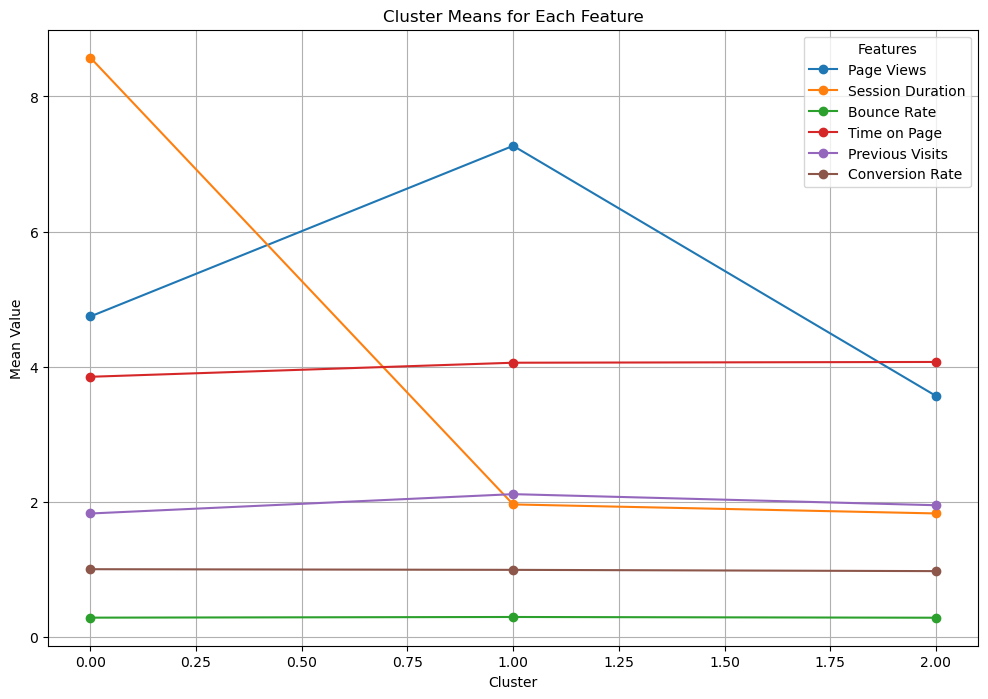

In [87]:
numericColumns = df.select_dtypes(include=[np.number]).columns
dfNumeric = df[numericColumns]

clusterMeans = dfNumeric.groupby('Cluster').mean()
print("\nCluster Analysis - Mean Values for Each Cluster:")
print(clusterMeans)

plt.figure(figsize=(12, 8))

for feature in clusterMeans.columns:
    plt.plot(clusterMeans.index, clusterMeans[feature], marker='o', label=feature)

plt.title('Cluster Means for Each Feature')
plt.xlabel('Cluster')
plt.ylabel('Mean Value')
plt.legend(title='Features')
plt.grid(True)
plt.show()
